In [83]:
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta
# 판다스 엑셀 익스포트를 위한 라이브러리
import openpyxl


PROJECT = "ballosodeuk"
bq = bigquery.Client(project=PROJECT)

In [84]:
query = """
WITH first_purchase AS (
  SELECT 
    user_id,
    MIN(register_dt) AS first_purchase_date
  FROM `dm.agg_user_cash_daily`
  WHERE purchase IS NOT NULL
  GROUP BY user_id
)

,final as
(SELECT DISTINCT a.user_id
  ,b.register_dt AS p_date
  ,b.current_shoji AS cur_shoji
  ,b.pre_shoji AS pre_shoji
  ,b.pre_cash AS pre_cash
  ,b.purchase AS p_amt
  ,b.spend_use - b.earn_recall - b.spend_burnt AS s_amt
  ,ROUND(
    (b.spend_use - b.earn_recall - b.spend_burnt) / NULLIF(b.purchase, 0)
  , 2) AS s_rto
  ,SUM(a.earn_exchange) OVER (
    PARTITION BY a.user_id
    ORDER BY a.register_dt
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  ) AS earn_exchange
  ,COUNT(a.earn_exchange) OVER (
    PARTITION BY a.user_id
    ORDER BY a.register_dt
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  ) AS earn_exchange_cnt
  ,SUM(a.earn_reward) OVER (
    PARTITION BY a.user_id
    ORDER BY a.register_dt
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  ) AS earn_reward
  ,COUNT(a.earn_reward) OVER (
    PARTITION BY a.user_id
    ORDER BY a.register_dt
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  ) AS since_visit_dt
  ,COUNT(case when a.earn_reward > 0 then a.earn_reward end) OVER (
    PARTITION BY a.user_id
    ORDER BY a.register_dt
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  ) AS earn_reward_cnt
FROM `dm.agg_user_cash_daily` a
JOIN first_purchase fp ON a.user_id = fp.user_id
JOIN `dm.agg_user_cash_daily` b 
  ON a.user_id = b.user_id 
  AND b.register_dt = fp.first_purchase_date
WHERE a.register_dt <= fp.first_purchase_date
  AND b.purchase IS NOT NULL)

select * from 
  (select *,row_number() over(partition by user_id order by earn_reward_cnt desc) as rnk
  from final)
where rnk = 1


"""

In [85]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [86]:
query = """
select distinct user_id, is_churn
from `dm.agg_user_churn_daily`
where is_churn is true
"""

In [87]:
churn = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [88]:
df = df.merge(churn,how='left',on='user_id')

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48138 entries, 0 to 48137
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            48138 non-null  object 
 1   p_date             48138 non-null  dbdate 
 2   cur_shoji          48138 non-null  Int64  
 3   pre_shoji          48138 non-null  Int64  
 4   pre_cash           46907 non-null  float64
 5   p_amt              48138 non-null  float64
 6   s_amt              48138 non-null  Int64  
 7   s_rto              48138 non-null  float64
 8   earn_exchange      48138 non-null  Int64  
 9   earn_exchange_cnt  48138 non-null  Int64  
 10  earn_reward        48138 non-null  Int64  
 11  since_visit_dt     48138 non-null  Int64  
 12  earn_reward_cnt    48138 non-null  Int64  
 13  rnk                48138 non-null  Int64  
 14  is_churn           15634 non-null  boolean
dtypes: Int64(9), boolean(1), dbdate(1), float64(3), object(1)
memory usage

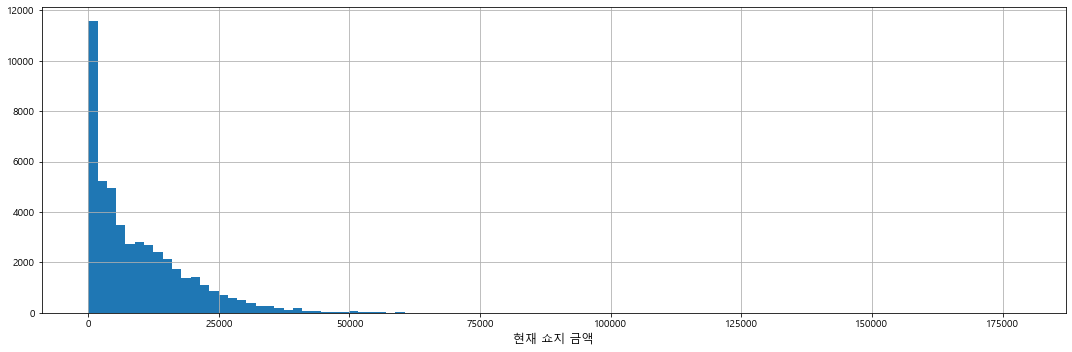

In [90]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
import pandas as pd

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우 맑은 고딕 폰트 경로
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 기존 히스토그램 그리기
plt.figure(figsize=(15, 5))
df.pre_shoji.hist(bins=100)
plt.xlabel('현재 쇼지 금액', fontsize=12)
plt.tight_layout()

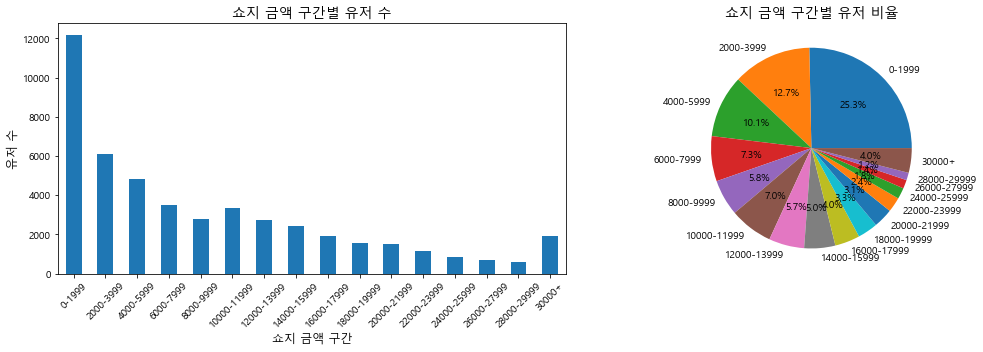

In [91]:
# pre_shoji를 2000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
bins = list(range(0, 30001, 2000)) + [float('inf')]
labels = [f'{i}-{i+1999}' for i in range(0, 30000, 2000)] + ['30000+']

# 구간화 및 각 구간별 유저 수 계산
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)
bin_counts = df['pre_shoji_bin'].value_counts().sort_index()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 첫 번째 그래프: 구간별 유저 수 막대 그래프
bin_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('쇼지 금액 구간별 유저 수', fontsize=14)
axes[0].set_xlabel('쇼지 금액 구간', fontsize=12)
axes[0].set_ylabel('유저 수', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 두 번째 그래프: 구간별 유저 비율 파이 차트
bin_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('쇼지 금액 구간별 유저 비율', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()


In [92]:
df['p_date'] = pd.to_datetime(df.p_date)
df.query("p_date >= '2025-01-01'").groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    # 'earn_reward_cnt': 'mean',
    'earn_reward_cnt': 'median',
    })


,user_id,pre_shoji,p_amt,s_amt,s_rto,earn_exchange,earn_reward,earn_reward_cnt
pre_shoji_bin,,,,,,,,
0-1999,7626,757.881852,15758.573302,2782.311172,0.279765,1729.614215,856.271702,15.0
2000-3999,5981,3007.277211,10010.439726,4338.961043,0.583759,2598.356128,2353.80739,32.0
4000-5999,4665,4974.928617,9444.668810,5749.126688,0.751089,3890.803644,2717.830011,38.0
6000-7999,3348,6958.603943,10589.865591,7025.510454,0.782599,5195.339008,2806.039427,39.0
8000-9999,2628,8969.499239,11538.694825,8724.921994,0.832983,7037.512557,2716.317352,42.0
10000-11999,3173,10918.215254,13467.513394,10912.85156,0.869199,9731.930035,2224.079105,34.0
12000-13999,2634,12981.103265,14810.846621,12497.656796,0.893971,11727.416856,2786.60858,47.0
14000-15999,2266,14969.029568,16008.503972,13821.883495,0.914784,13306.22639,3014.943513,49.0
16000-17999,1858,16962.120022,16961.851453,14960.383208,0.921722,14871.646394,3146.59634,49.0


<Axes: >

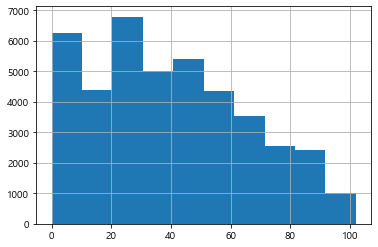

In [93]:
df.query("p_date >= '2025-01-01'").earn_reward_cnt.hist()

In [94]:
# BigQuery에서 가져온 데이터는 때때로 타입 문제가 발생할 수 있습니다.
# 'earn_reward_cnt' 열의 타입을 명시적으로 변환해 보겠습니다.
df['earn_reward_cnt'] = df['earn_reward_cnt'].astype(float)

# 참고: df = bq.query(query).to_dataframe()으로 BigQuery에서 데이터를 가져올 때
# 'unknown type object' 오류가 발생할 수 있습니다. 이는 pandas와 BigQuery 간의
# 데이터 타입 호환성 문제로 인한 것입니다.

In [120]:
df['pre_cash'] = df['pre_cash'].fillna(0)
# 5000 단위로 구간 설정
bins = list(range(0, 30001, 5000)) + [float('inf')]
labels = [f'{i}-{i+4999}' for i in range(0, 30000, 5000)] + ['30000+']

# pre_cash와 pre_shoji 모두 5000 단위로 구간화하고, 3만 이상은 하나의 구간으로 통합
df['pre_cash_bin'] = pd.cut(df['pre_cash'], bins=bins, labels=labels, right=False)
df['pre_shoji_bin'] = pd.cut(df['pre_shoji'], bins=bins, labels=labels, right=False)

In [111]:
df.groupby('pre_cash_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn      pre_cash     pre_shoji         p_amt  \
               count    count          mean          mean          mean   
pre_cash_bin                                                              
0-4999         23495     8102    354.087934  13529.036944  15258.875505   
2000-6999       3924     1427   3002.751784   8051.428644  14204.589704   
4000-8999       3232     1090   4993.745050   7116.886757  15039.439975   
6000-10999      2437      836   6953.731227   5847.345917  14547.496922   
8000-12999      1959      583   8987.945380   5228.325676  14785.472180   
10000-14999     2440      789  10924.300820   4818.443443  15249.860656   
12000-16999     1846      526  12957.209642   4656.927952  15386.879740   
14000-18999     1656      428  14988.087560    4318.06401  15244.945652   
16000-20999     1370      326  16972.044526   4164.610219  16256.744526   
18000-22999     1176      275  18977.076531   4198.256803  16329.345238   
20000-24999      997      288  20977.918756   3892.891675  16474.663992   
22000-26999      756      186  22919.240741   4186.378307  19776.587302   
24000-28999      573      154  24967.689354   4431.893543  18263.909250   
26000-30999      416      102  26985.435096   4377.298077  17589.062500   
28000-32999      358       91  28966.290503   4708.879888  20448.826816   
30000+          1497      430  46154.557782   5225.805611  25774.154977   

                     s_amt     s_rto earn_exchange  earn_reward  \
                      mean      mean          mean         mean   
pre_cash_bin                                                      
0-4999        11247.937093  0.787761  11376.241966  2769.630347   
2000-6999       7010.10423  0.567518   8950.566514  1773.668451   
4000-8999      6836.422339  0.553861   8979.154703  1736.341584   
6000-10999     6012.947887  0.516516   7388.403775  1673.712351   
8000-12999     5307.459929  0.485263    6077.93415  1899.993364   
10000-14999    7458.356557  0.587488   7752.972951  1839.569262   
12000-16999    6393.351029  0.532140   6743.273564  1953.901408   
14000-18999    5734.883454  0.502301   6379.135266  1968.858696   
16000-20999    5473.414599  0.473715    6308.69635   1945.69927   
18000-22999    5219.954932  0.472117   6329.239796  1986.159864   
20000-24999    5363.751254  0.471625   6591.334002  1901.888666   
22000-26999    5161.193122  0.432870   7460.300265  1961.777778   
24000-28999    5010.513089  0.434188   7770.846422  1942.219895   
26000-30999    4276.939904  0.393221   8156.569712  1735.283654   
28000-32999    4131.807263  0.354302   8899.860335  1718.726257   
30000+         2697.563126  0.197742  18559.963928   790.680695   

             earn_reward_cnt             
                      median       mean  
pre_cash_bin                             
0-4999                  45.0  42.915769  
2000-6999               26.0  28.965341  
4000-8999               27.0  29.289604  
6000-10999              25.0  27.428396  
8000-12999              26.0  28.272588  
10000-14999             28.0  29.333607  
12000-16999             28.0  29.115926  
14000-18999             28.0  29.887681  
16000-20999             27.0  28.204380  
18000-22999             27.0  27.841837  
20000-24999             26.0  26.833501  
22000-26999             25.0  26.407407  
24000-28999             21.0  25.801047  
26000-30999             15.0  22.060096  
28000-32999             12.0  21.061453  
30000+                   0.0   9.106212

In [112]:
df.groupby('pre_shoji_bin').agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })


user_id is_churn      pre_cash     pre_shoji         p_amt  \
                count    count          mean          mean          mean   
pre_shoji_bin                                                              
0-1999          12195     5755  13057.497089     485.15162  18735.494055   
2000-3999        6110     1676   9749.416530   3008.973159  10192.684124   
4000-5999        4845     1401   7311.450980   4975.841692   9817.461300   
6000-7999        3493     1107   5378.875179   6962.338677  10993.790438   
8000-9999        2798      936   3486.099357   8983.782345  12033.348821   
10000-11999      3359     1252   3395.335517  10906.910985  13881.265258   
12000-13999      2747      775   3083.214416  12977.812159  15203.651256   
14000-15999      2408      680   2853.457226  14971.581811  16321.947674   
16000-17999      1937      504   2254.298916  16959.183789  17426.391327   
18000-19999      1568      359   2025.468112  19003.910714  18285.797194   
20000-21999      1504      338   2165.825133  20903.447473  19968.251330   
22000-23999      1150      216   2000.708696  22982.766957  20695.434783   
24000-25999       863      140   2024.606025  24971.228273  21058.841251   
26000-27999       672      114   1748.964286  26943.678571  22516.145833   
28000-29999       578       98   1921.124567  28970.017301  23065.640138   
30000+           1911      283   4366.504448  38190.050759  28137.221350   

                      s_amt     s_rto earn_exchange  earn_reward  \
                       mean      mean          mean         mean   
pre_shoji_bin                                                      
0-1999          2166.035424  0.194021    4631.98442   539.061665   
2000-3999       4284.423241  0.576002    2617.24599  2304.438953   
4000-5999       5623.321775  0.732518    3961.48999    2617.4516   
6000-7999        6850.87432  0.760796   5314.718294  2689.917836   
8000-9999       8409.498928  0.800329   7277.867048  2553.012866   
10000-11999    10590.862161  0.843370   9886.452516  2102.338196   
12000-13999    12207.186385  0.872304  11870.529305  2673.419731   
14000-15999    13381.546096  0.886026  13596.181894  2838.554817   
16000-17999    14614.399587  0.899969  15096.610738  3019.185338   
18000-19999    15549.204082  0.897468  17318.503827  3101.741709   
20000-21999    16753.884973  0.893265  19534.774601  3048.117686   
22000-23999    17520.074783  0.902791  21291.672174  3387.812174   
24000-25999     18523.21321  0.917497  23102.974508  3814.882966   
26000-27999    19607.840774  0.920461    24954.5625  3943.544643   
28000-29999    20199.543253  0.913668   27297.17474  3985.306228   
30000+         23044.316065  0.868425  41101.361068   5381.22763   

              earn_reward_cnt             
                       median       mean  
pre_shoji_bin                             
0-1999                    4.0  11.624272  
2000-3999                32.0  36.091162  
4000-5999                36.0  41.769866  
6000-7999                36.0  42.195248  
8000-9999                39.0  41.310579  
10000-11999              32.0  36.130694  
12000-13999              46.0  43.580269  
14000-15999              47.0  44.792774  
16000-17999              48.0  47.217863  
18000-19999              50.0  48.149235  
20000-21999              49.0  46.378989  
22000-23999              52.0  50.775652  
24000-25999              57.0  54.435689  
26000-27999              58.0  55.409226  
28000-29999              57.0  54.832180  
30000+                   54.0  46.895866

In [113]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [121]:
df.groupby(['pre_shoji_bin','pre_cash_bin']).agg({
    'user_id': 'count',
    'is_churn': 'count',
    'pre_cash': 'mean',
    'pre_shoji': 'mean',
    'p_amt': 'mean',
    's_amt': 'mean',
    's_rto': 'mean',
    'earn_exchange': 'mean',
    'earn_reward': 'mean',
    'earn_reward_cnt': ['median','mean'],
    })

user_id is_churn      pre_cash     pre_shoji  \
                             count    count          mean          mean   
pre_shoji_bin pre_cash_bin                                                
0-4999        0-4999          7155     3457   1734.512089   1971.901048   
              5000-9999       3987     1559   7223.159268   1489.522197   
              10000-14999     3603     1233  12263.840966   1686.988621   
              15000-19999     2458      673  17316.003662   1790.821806   
              20000-24999     1482      470  22174.419028   1564.838731   
              25000-29999      748      243  27245.651070   1406.078877   
              30000+          1180      368  47762.374576    630.224576   
5000-9999     0-4999          6192     2412    816.007267    7341.19832   
              5000-9999        799      208   7439.758448   6680.664581   
              10000-14999      680      129  12324.567647   6792.558824   
              15000-19999      511       66  17313.547945    6698.34638   
              20000-24999      346       33  22287.471098   6726.985549   
              25000-29999      180       10  27241.900000   6842.322222   
              30000+           117       13  37370.837607   6928.615385   
10000-14999   0-4999          5705     1978    660.558633  12305.832428   
              5000-9999        693      179   6975.522367  12187.279942   
              10000-14999      536      144  12019.080224  12241.979478   
              15000-19999      213       40  17182.079812  12255.976526   
              20000-24999      101       17  22108.960396  11868.584158   
              25000-29999       43        6  27190.372093  11995.511628   
              30000+            31        3  35983.903226  11806.580645   
15000-19999   0-4999          4099     1116    582.128324  17312.241522   
              5000-9999        205       31   7153.995122  16826.258537   
              10000-14999      164       21  12362.591463  16855.457317   
              15000-19999      105       16  17556.704762  16789.857143   
              20000-24999       67       14  22259.865672  17027.895522   
              25000-29999       31        1  27198.548387  17557.322581   
              30000+            25        4  40309.400000       17601.8   
20000-24999   0-4999          2735      571    591.333090  22199.552468   
              5000-9999        171       28   6924.888889  22104.070175   
              10000-14999       76        6  11969.644737  22314.907895   
              15000-19999       40        7  17310.225000      21842.65   
              20000-24999       33        9  22345.848485  22000.757576   
              25000-29999       20        5  27555.050000       22070.8   
              30000+            19        4  38562.684211  21893.315789   
25000-29999   0-4999          1530      261    532.528105   27274.80719   
              5000-9999         51        3   7465.921569  27176.392157   
              10000-14999       30        2  11905.866667  27114.466667   
              15000-19999       17        1  16805.058824  27516.470588   
              20000-24999       10        3  22375.200000       27057.6   
              25000-29999       15        3  28075.666667  27180.266667   
              30000+            18        3  37951.611111  27380.944444   
30000+        0-4999          1576      220    705.274112  37309.409898   
              5000-9999        149       15   6882.691275   44536.09396   
              10000-14999       34        2  12010.382353  39073.970588   
              15000-19999       21        4  17132.761905  35542.571429   
              20000-24999        9        0  22762.666667  38155.444444   
              25000-29999       15        7  27468.333333  38235.466667   
              30000+           107       35  45068.476636  42559.242991   

                                   p_amt         s_amt     s_rto  \
                                    mean          mean    